# Лабораторная работа №2. Вариант 2.
## Клименко Виталий Б01-203
### Лабораторная работа 2 Системы ОДУ (жесткий вариант)

Решить систему ОДУ следующими методами: 
0) Попробовать использовать для решения один из методов 3 или 4 порядка лабы 1 .
1) Неявный метод Рунге-Кутта 3 порядка и выше (можно двух стадийный метод найти) 
2) Неявный метод Адамса или ФДН (методы Гира) 3 порядка и выше (внимание разгонный участок!) 
3) метод Розенброка-Ваннера 2 и 3 порядка или выше (внимание автономная или неавтономная система ОДУ!) 
4)* методы Гира в представлении Нордсика 

ВАЖНО! 1.Если удалось взять явной схемой , то зафиксировать h опытным путем, при котором наблюдается устойчивая картина. 

2. Для 1) , 2) , 3) - подобрать h опытным путем, для теста метода можно пробовать сначала "скормить" нежесткую систему , решенную в Лабе1


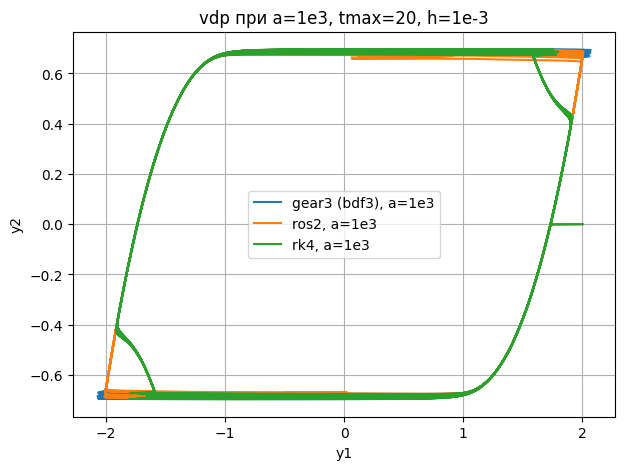

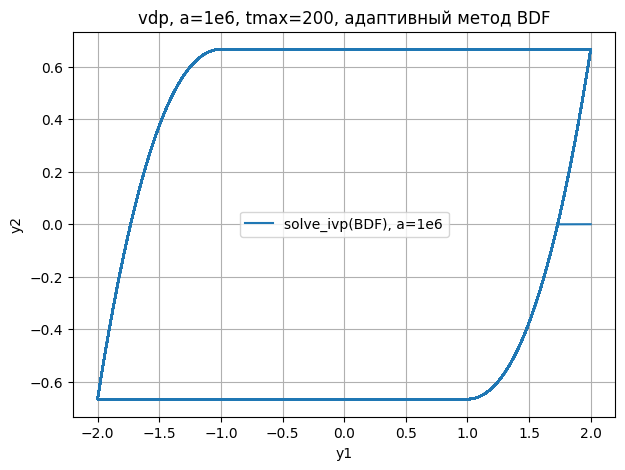

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# --- система ван-дер-поля (неавтономная) с аналитическим якобианом ---

# f(t, y)
# y1' = a*(-((y1^3)/3 - y1) + y2)
# y2' = -y1 + A*cos(omega*t)
def vdp_f(t, y, a=1e3, A=0.5, omega=1.0):
    y1, y2 = y
    dy1 = a*(-((y1**3)/3 - y1) + y2)
    dy2 = -y1 + A*np.cos(omega*t)
    return np.array([dy1, dy2])

# аналитический якобиан df/dy
# df1/dy1 = a*( - d/dy1((y1^3)/3 - y1) ) = a*( - (y1^2 - 1)) = a*(1 - y1^2)
# df1/dy2 = a
# df2/dy1 = -1
# df2/dy2 = 0
def vdp_jac(t, y, a=1e3, A=0.5, omega=1.0):
    # y1 = np.clip(y[0], -1e10, 1e10)
    y1, _ = y
    j11 = a*(1 - y1**2)
    j12 = a
    j21 = -1.0
    j22 = 0.0
    return np.array([[j11, j12],
                     [j21, j22]])

# --- вспомогательный явный метод rk4 (мелкий шаг) ---
def rk4(func, y0, t0, tmax, h, *params):
    n_steps = int((tmax - t0)//h)
    t_vals = np.zeros(n_steps+1)
    sol = np.zeros((n_steps+1, len(y0)))
    sol[0] = y0
    t_vals[0] = t0
    for i in range(n_steps):
        tn = t_vals[i]
        yn = sol[i]
        k1 = func(tn, yn, *params)
        k2 = func(tn+0.5*h, yn+0.5*h*k1, *params)
        k3 = func(tn+0.5*h, yn+0.5*h*k2, *params)
        k4 = func(tn+h, yn+h*k3, *params)
        sol[i+1] = yn + (h/6)*(k1+2*k2+2*k3+k4)
        t_vals[i+1] = tn+h
    return t_vals, sol

# --- неявный bdf3 (gear3) с аналитическим якобианом ---
# 11 y_{n+1} -18 y_n +9 y_{n-1} -2 y_{n-2} = 6h f(t_{n+1}, y_{n+1})
def gear3(func_f, func_jac, y0, t0, tmax, h, max_iter=10, tol=1e-9, *params):
    n_steps = int((tmax - t0)//h)
    t_vals = np.zeros(n_steps+1)
    sol = np.zeros((n_steps+1, len(y0)))
    sol[0] = y0
    t_vals[0] = t0

    # разгон 2 шага rk4
    def rk4_step(tt, yy, hh):
        k1 = func_f(tt, yy, *params)
        k2 = func_f(tt+0.5*hh, yy+0.5*hh*k1, *params)
        k3 = func_f(tt+0.5*hh, yy+0.5*hh*k2, *params)
        k4 = func_f(tt+hh, yy+hh*k3, *params)
        return yy + (hh/6)*(k1+2*k2+2*k3+k4)

    if n_steps>=1:
        sol[1] = rk4_step(t0, y0, h)
        t_vals[1] = t0 + h
    if n_steps>=2:
        sol[2] = rk4_step(t0+h, sol[1], h)
        t_vals[2] = t0 + 2*h

    for i in range(2, n_steps):
        tn1 = t0 + (i+1)*h
        y_guess = sol[i].copy()
        for _ in range(max_iter):
            f_val = func_f(tn1, y_guess, *params)
            g_val = 11*y_guess - 6*h*f_val - (18*sol[i] - 9*sol[i-1] + 2*sol[i-2])
            if np.linalg.norm(g_val) < tol:
                break
            j_val = func_jac(tn1, y_guess, *params)
            # dg/dy = 11I - 6h J
            J_mat = 11*np.eye(len(y0)) - 6*h*j_val
            try:
                dy = np.linalg.solve(J_mat, g_val)
            except np.linalg.LinAlgError:
                dy = np.zeros_like(y_guess)
            y_guess = y_guess - dy
        sol[i+1] = y_guess
        t_vals[i+1] = tn1
    return t_vals, sol

# --- метод розенброка (2 порядка) ---
# (I - gamma*h*J)k1 = f
# (I - gamma*h*J)k2 = f(tn+alpha*h, yn+alpha*h*k1) - gamma*h*J( ... ) ...
# упрощённая версия 2-го порядка
def rosenbrock2(func_f, func_jac, y0, t0, tmax, h, gamma=0.5, max_iter=1, *params):
    n_steps = int((tmax - t0)//h)
    t_vals = np.zeros(n_steps+1)
    sol = np.zeros((n_steps+1, len(y0)))
    sol[0] = y0
    t_vals[0] = t0

    alpha = 1.0  # одна из простых реализаций
    for i in range(n_steps):
        tn = t_vals[i]
        yn = sol[i]
        # стадия 1
        Jn = func_jac(tn, yn, *params)
        A = np.eye(len(y0)) - gamma*h*Jn
        f0 = func_f(tn, yn, *params)
        try:
            k1 = np.linalg.solve(A, f0)
        except np.linalg.LinAlgError:
            k1 = f0.copy()

        # стадия 2
        y_tilde = yn + alpha*h*k1
        f_tilde = func_f(tn+alpha*h, y_tilde, *params)
        # (I - gamma*h*Jn)k2 = f_tilde - gamma*h*Jn*k1
        rhs2 = f_tilde - gamma*h*Jn.dot(k1)
        try:
            k2 = np.linalg.solve(A, rhs2)
        except np.linalg.LinAlgError:
            k2 = rhs2.copy()

        # итог
        sol[i+1] = yn + 0.5*h*(k1 + k2)
        t_vals[i+1] = tn + h

    return t_vals, sol

if __name__ == "__main__":
    # 1) пример: a=1e3, tmax=20, шаг 1e-3. методы gear3, rosenbrock2, rk4.
    #    здесь задача ещё не супер-жёсткая, всё считается быстро.
    a_test = 1e3
    A_par = 0.9
    w_par = 1.0
    y0 = np.array([2.0, 0.0])
    t0, tmax = 0.0, 20.0
    h = 1e-3

    # gear3
    t_g3, s_g3 = gear3(vdp_f, vdp_jac, y0, t0, tmax, h, 10, 1e-9, a_test, A_par, w_par)
    # rosenbrock2
    t_r2, s_r2 = rosenbrock2(vdp_f, vdp_jac, y0, t0, tmax, h, 0.5, 1, a_test, A_par, w_par)
    # rk4 (явный, потребует много шагов, но при a=1e3 ещё терпимо)
    t_rk4, s_rk4 = rk4(vdp_f, y0, t0, tmax, h, a_test, A_par, w_par)

    plt.figure(figsize=(7,5))
    plt.plot(s_g3[:,0], s_g3[:,1], label='gear3 (bdf3), a=1e3')
    plt.plot(s_r2[:,0], s_r2[:,1], label='ros2, a=1e3')
    plt.plot(s_rk4[:,0], s_rk4[:,1], label='rk4, a=1e3')
    plt.title('vdp при a=1e3, tmax=20, h=1e-3')
    plt.xlabel('y1')
    plt.ylabel('y2')
    plt.grid(True)
    plt.legend()
    plt.show()

    #    ниже пример BDF на [0,200].
    a_big = 1e6
    tmax_big = 200.0

    sol_scipy = solve_ivp(
        lambda tt, yy: vdp_f(tt, yy, a_big, A_par, w_par),
        [t0, tmax_big],
        y0,
        method='BDF',    # неявный метод, подходящий для жёстких задач
        max_step=1e-1,   # максимально допустимый шаг (можно попробовать 1e-1 или больше)
        atol=1e-8,
        rtol=1e-8
    )

    plt.figure(figsize=(7,5))
    plt.plot(sol_scipy.y[0], sol_scipy.y[1], label='solve_ivp(BDF), a=1e6')
    plt.title('vdp, a=1e6, tmax=200, адаптивный метод BDF')
    plt.xlabel('y1')
    plt.ylabel('y2')
    plt.grid(True)
    plt.legend()
    plt.show()


# Заключение

Использовали неявные схемы — Рунге–Кутта, bdf (Гира), Розенброкa и т. д.  У жёстких уравнений наблюдается сильная чувствительность при использовании явных методов. 
